# Fallbeispiel eines Tracks für das Evaluierungsposter

Für das Evaluierungsposter brauchen wir ein nettes Beispiel eines Tracks.

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd

from plotting_tools.colormaps import enhanced_colormap
emap = enhanced_colormap()

%matplotlib inline

import glob
import os
from scipy import ndimage as ndi
from skimage.measure import find_contours
from skimage import color

In [3]:
def normalise2range(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def array_to_256(array):
    return (array*255.999).astype("uint8")

def day_natural_composite(vis006_data,vis008_data,nir016_data,factor=1,gamma=1):
    blue = array_to_256(np.clip(vis006_data/factor,0,1)**(1./gamma))
    green = array_to_256(np.clip(vis008_data/factor,0,1)**(1./gamma))
    red = array_to_256(np.clip(nir016_data/factor,0,1)**(1./gamma))
    
    return np.dstack([red,green,blue]).astype("uint8")

def scale_array_min_max(array_data,range_min=0,range_max=1):
    """
    Scales a array into the chosen range.
    
    Inputs:
    -------
    array_data: numpy array of floats or integers, 2d
        array to scale
    range_min: int or float, default = 0
        minimum value of the range to scale array to,
    range_max: int or float, default = 1
        maximum value of the range to scale array to,
        
    Returns:
    --------
    scaled_array: numpy array of floats, 2d
    """
    # get array extrema
    array_min = np.min(array_data)
    array_max = np.max(array_data)

    # derive conversion parameters
    a = (range_max - range_min) / (array_max - array_min)
    b = range_max - a * array_max

    # scale array
    scaled_array = a * array_data + b
    
    return scaled_array

def add_hrv_texture2nc(nc,hrv):
    nc_lab = color.rgb2lab(nc)
    l_min = nc_lab[...,0].min()
    l_max = nc_lab[...,0].max()
    
    l_hrv_scaled = nc_lab[...,0] * hrv
    l_hrv_scaled = scale_array_min_max(l_hrv_scaled,l_min,l_max)

    nc_lab[...,0] = l_hrv_scaled
    
    return color.lab2rgb(nc_lab)

In [4]:
talos_home = "/vols/talos/home/stephan"
data_path = "{talos_home}/data".format(talos_home=talos_home)
track_data_path = "{dp}/radar_track/trackdata".format(dp=data_path)

In [5]:
track_paths = glob.glob("{tdp}/*.nc".format(tdp=track_data_path))

In [6]:
def get_track_id_from_file_path(file_path):
    import os
    file_name = os.path.basename(file_path)

    track_id = "{}_{}".format(file_name.split(".")[0].split("_")[-2],
                              file_name.split(".")[0].split("_")[-1])
    
    return track_id

In [7]:
track_example = xr.open_dataset(track_paths[55])

In [8]:
nc_rgbs = np.array([day_natural_composite(track_example.vis006.data[i],
                                          track_example.vis008.data[i],
                                          track_example.ir016.data[i],0.9,1.8) 
                    for i in xrange(len(track_example.ir108.data))])

Als nächstes suchen wir uns die bewölkten Bereiche aus dem HRV-Kanal, um Konturen zu bestimmen.

In [9]:
labelled = []
contours = []
centroids = []
for h in track_example.hrv.data:
    m = np.ma.masked_less(h,0.3)
    l,nl = ndi.label(~m.mask*1)
    labelled.append(l)
    
    cont = find_contours(l,1)
    contours.append(cont)
    
    cent = ndi.measurements.center_of_mass(m, l, np.arange(1,nl))
    centroids.append(cent)

In [10]:
objects = ndi.measurements.find_objects(labelled)

In [11]:
objects

[(slice(0L, 13L, None), slice(18L, 53L, None), slice(136L, 152L, None)),
 (slice(0L, 13L, None), slice(50L, 84L, None), slice(60L, 151L, None)),
 (slice(0L, 13L, None), slice(51L, 84L, None), slice(57L, 150L, None)),
 (slice(0L, 13L, None), slice(52L, 83L, None), slice(56L, 153L, None)),
 (slice(0L, 13L, None), slice(54L, 83L, None), slice(23L, 153L, None)),
 (slice(0L, 13L, None), slice(55L, 83L, None), slice(32L, 153L, None)),
 (slice(0L, 13L, None), slice(56L, 83L, None), slice(20L, 153L, None)),
 (slice(0L, 13L, None), slice(58L, 80L, None), slice(22L, 152L, None)),
 (slice(0L, 13L, None), slice(59L, 87L, None), slice(22L, 142L, None)),
 (slice(0L, 13L, None), slice(62L, 97L, None), slice(24L, 127L, None)),
 (slice(0L, 13L, None), slice(67L, 97L, None), slice(26L, 121L, None)),
 (slice(0L, 13L, None), slice(68L, 98L, None), slice(32L, 140L, None)),
 (slice(0L, 13L, None), slice(69L, 98L, None), slice(35L, 136L, None)),
 (slice(0L, 13L, None), slice(71L, 99L, None), slice(28L, 141L,

In [12]:
oid = labelled[6][labelled[6].shape[0]//2,labelled[6].shape[1]//2]
print oid

9


In [13]:
objects[oid]

(slice(0L, 13L, None), slice(62L, 97L, None), slice(24L, 127L, None))

In [14]:
contours[6]

[array([[ 54.5, 119. ],
        [ 54.5, 118. ],
        [ 54. , 117.5],
        [ 53.5, 117. ],
        [ 53. , 116.5],
        [ 52.5, 117. ],
        [ 52. , 117.5],
        [ 51.5, 118. ],
        [ 52. , 118.5],
        [ 52.5, 119. ],
        [ 53. , 119.5],
        [ 54. , 119.5],
        [ 54.5, 119. ]]), array([[ 53.66666667, 145.        ],
        [ 53.        , 144.33333333],
        [ 52.        , 144.33333333],
        [ 51.33333333, 145.        ],
        [ 52.        , 145.66666667],
        [ 53.        , 145.66666667],
        [ 53.66666667, 145.        ]]), array([[ 54.75, 137.  ],
        [ 54.  , 136.25],
        [ 53.  , 136.25],
        [ 52.25, 137.  ],
        [ 52.25, 138.  ],
        [ 53.  , 138.75],
        [ 53.75, 138.  ],
        [ 54.  , 137.75],
        [ 54.75, 137.  ]]), array([[ 54.8, 114. ],
        [ 54.8, 113. ],
        [ 54. , 112.2],
        [ 53.2, 113. ],
        [ 53.2, 114. ],
        [ 54. , 114.8],
        [ 54.8, 114. ]]), array([[ 55.833

In [15]:
cutout = {'hrv':[],'vis006':[],'vis008':[],'ir016':[],'ir108':[]}

for i,h in enumerate(track_example.hrv.data):
    cutout['hrv'].append(h[45:90,50:125])
    cutout['vis006'].append(track_example.vis006.data[i][45:90,50:125])
    cutout['vis008'].append(track_example.vis008.data[i][45:90,50:125])
    cutout['ir016'].append(track_example.ir016.data[i][45:90,50:125])
    cutout['ir108'].append(track_example.ir108.data[i][45:90,50:125])

In [16]:
labelled = []
contours = []
centroids = []
for h in cutout['hrv']:
    m = np.ma.masked_less(ndi.gaussian_filter(h,1.5),0.3)
    l,nl = ndi.label(~m.mask*1)
    labelled.append(l)
    
    cont = find_contours(l,0.8)
    contours.append(cont)
    
    cent = ndi.measurements.center_of_mass(m, l, np.arange(1,nl+1))
    centroids.append(cent)

In [17]:
nc_rgbs = np.array([day_natural_composite(cutout['vis006'][i],
                                          cutout['vis008'][i],
                                          cutout['ir016'][i],0.9,1.8) 
                    for i in xrange(len(cutout['ir108']))])

In [18]:
m = np.ma.masked_less(cutout['hrv'],0.3)
labelled,nl = ndi.label(~m.mask*1)

In [19]:
oid = labelled[6][25,25]
print oid

3


In [20]:
contours = []
centroids = []

for i,l in enumerate(labelled):
    lm = np.ma.masked_not_equal(l,oid)
    cont = find_contours(~lm.mask*1,0.8)
    contours.append(cont)
    
    cent = ndi.measurements.center_of_mass(m[i], ~lm.mask*1, [1])
    centroids.append(cent)

In [21]:
lm = np.ma.masked_not_equal(labelled[0],oid)

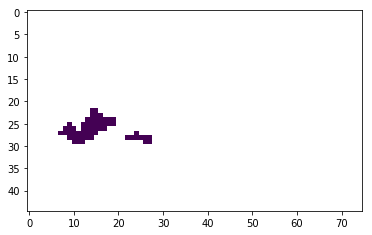

In [22]:
plt.imshow(lm)

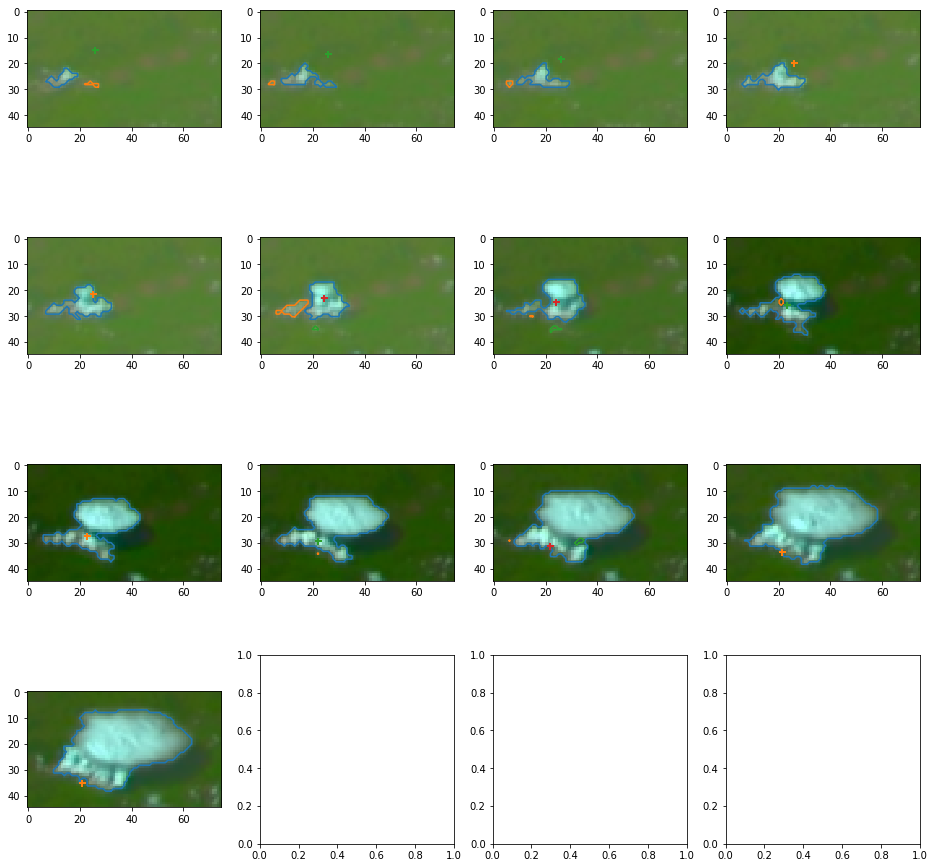

In [23]:
fig,ax = plt.subplots(4,4,figsize=(16,16))
axs=ax.ravel()

for i,h in enumerate(cutout['hrv']):
    #axs[i].imshow(nc_rgbs[i])
    #axs[i].imshow(labelled[i])
    axs[i].imshow(add_hrv_texture2nc(nc_rgbs[i],cutout['hrv'][i]))
    for cont in contours[i]:
        axs[i].plot(cont[:,1],cont[:,0])
        
    for cent in centroids[i]:
        axs[i].plot(cent[0],cent[1],marker='+',mew=2,markersize=7)

In [24]:
import matplotlib as mpl
cmap = mpl.cm.get_cmap('plasma')
norm = mpl.colors.Normalize(vmin=0, vmax=np.max(np.unique(labelled)))
alpha=np.linspace(0.4,1,13)
lwd = np.linspace(2./13,1.5,13)
ms = np.linspace(3,7,13)

In [25]:
cr = [c[0][0] for c in centroids]
cc = [c[0][1] for c in centroids]

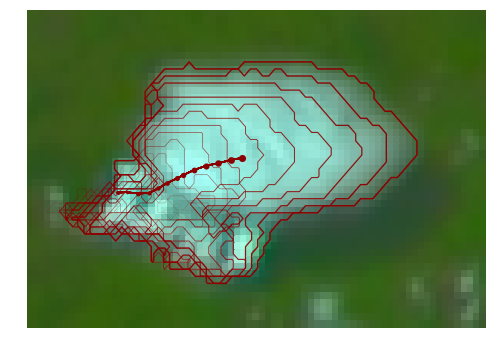

In [88]:
fig,ax = plt.subplots(1,1,figsize=(7,5))
nc = add_hrv_texture2nc(nc_rgbs[-1],cutout['hrv'][-1])
colour_tuples =  np.array([nc[...,0].flatten(), 
                           nc[...,1].flatten(),
                           nc[...,2].flatten()]).transpose()

#ax.imshow(add_hrv_texture2nc(nc_rgbs[-1],cutout['hrv'][-1]))
im = ax.pcolormesh(nc[...,0], color=colour_tuples)
im.set_array(None)
ax.invert_yaxis()
for i,h in enumerate(cutout['hrv']):
    #for cont in contours[i]:
    #    ax.plot(cont[:,1],cont[:,0],color=cmap(norm(oid))
    
    for oid,co in enumerate(contours[i]):
         ax.plot(co[:,1]+0.5, co[:,0]+0.5, 
                    #linewidth=1,
                    color='darkred',
                    alpha = alpha[i],
                    linewidth = lwd[i])
            
    for oid,ce in enumerate(centroids[i]):
        if len(ce) > 0:
             ax.plot(ce[1],ce[0],
                 color='darkred',
                 marker='o',
                 markersize = ms[i],
                 mew=0.1)
        else:
             continue
    ax.plot(cc,cr,color='darkred',linestyle='solid',linewidth=1.5)
    plt.axis('off')  
    plt.tight_layout()
    #plt.savefig("/vols/talos/home/stephan/pics/trackbeispiel.png",dpi=300)
    plt.savefig("/vols/talos/home/stephan/pics/trackbeispiel.eps")
    #for cent in centroids[i]:
    #    ax.plot(cent[1],cent[0],marker='+',mew=2,markersize=7)

In [27]:
centroids[1][0]

(25.766978372972147, 16.262545871047347)

In [28]:
for co in contours:
    print co   
    for oid,c in co:
        if 

SyntaxError: invalid syntax (<ipython-input-28-11c814d5c73f>, line 4)

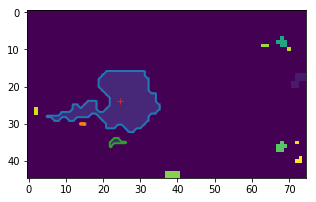

In [29]:
fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.imshow(labelled[6])
for n, contour in enumerate(contours[6]):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
    
for n, cent in enumerate(centroids[6]):
    ax.plot(cent[1],cent[0], marker='+')

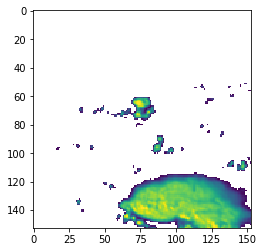

In [30]:
plt.imshow(np.ma.masked_less(track_example.hrv.data[6],0.3))

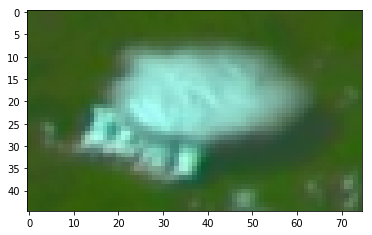

In [50]:
plt.imshow(add_hrv_texture2nc(n,cutout['hrv'][-1]))

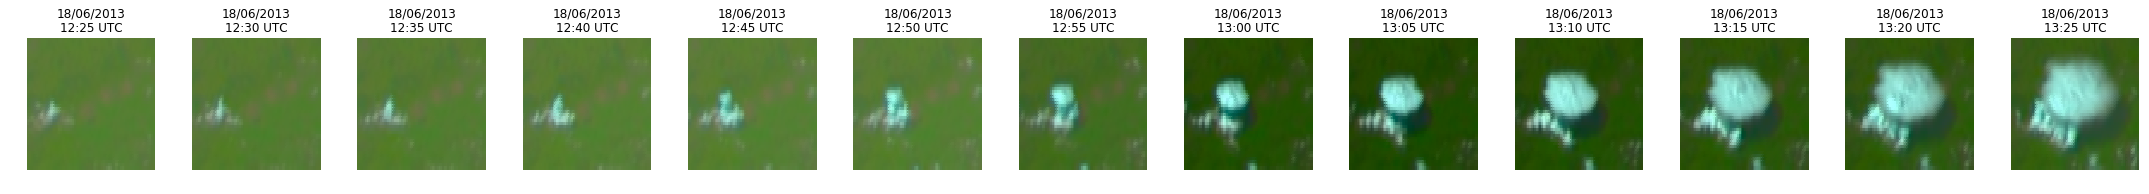

In [92]:
fig,ax = plt.subplots(1,13,figsize=(30,2.8))

for i,n in enumerate(nc_rgbs):
    nc = add_hrv_texture2nc(n,cutout['hrv'][i])
    colour_tuples =  np.array([nc[...,0].flatten(), 
                               nc[...,1].flatten(),
                               nc[...,2].flatten()]).transpose()
    im = ax[i].pcolormesh(nc[...,0], color=colour_tuples)
    im.set_array(None)
    ax[i].invert_yaxis()
    ax[i].set_title(pd.to_datetime(track_example.time.data[i]).strftime("%d/%m/%Y\n%H:%M UTC"))
    ax[i].axis("off")
    
plt.tight_layout()
plt.savefig("/vols/talos/home/stephan/pics/poster_trackbeispiel.pdf")

In [55]:
test = add_hrv_texture2nc(n,cutout['hrv'][-1])

In [72]:
test[...,0].shape

(45, 75)

In [76]:
color_tuples = np.array([test[...,0].flatten(), test[...,1].flatten(), test[...,2].flatten()]).transpose()

In [73]:
color_tuples.shape


(10000, 3)

In [74]:
45*75

3375

Text(0.5,1,'pcolormesh with coordinates')

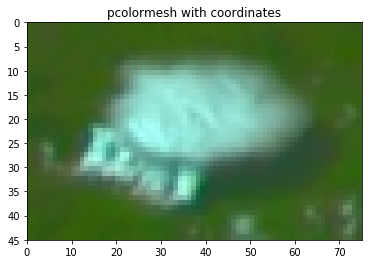

In [81]:
im = plt.pcolormesh(test[...,0], color=color_tuples)
im.set_array(None)
plt.gca().invert_yaxis()
plt.title('pcolormesh with coordinates')